*Adapted from the keras example https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py*


This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/X_deep_learning/)

Given the computational load, an efficient alternative is to use the UGA's jupyterhub service https://jupyterhub.u-ga.fr/ .
In this case, to install tensorflow 2.X, just type

    !pip install --user --upgrade tensorflow

in a code cell, then restart the notebook (or just restart the kernel)

# Logistic regression and multiple layer perceptron to process MNIST dataset with Keras

The objective of this notebook is to code/train/test some neural net models with the [TensorFlow](https://www.tensorflow.org/) ML platform developped by Google using the [Keras API](https://keras.io/) (integrated in TensorFlow).



MNIST is a simple computer vision dataset. It consists of images of handwritten digits. It also includes labels for each image, telling us which digit it is. In this lab session, we're going to train a model to look at images and predict what digits they are.

The cells below allow us to
- [Load/Format/Display MNIST data](#I.-Load-and-format-MNIST-data)
- [Code a Multinomial Logistic Regression](#II.-Multinomial-Logistic-Regression)
- [Code a Multi-Layers Network to reach at least 98% of correct classification](#III.-Multiple-layer-network)

## I. Load and format MNIST data

First, start here with these lines of code which will download and read in the data automatically:

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

The MNIST data is split into two parts: 60,000 data points of training data, 10,000 points of test data. It's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

Every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. "x" corresponds to images and "y" to labels. Both the training set and test set contain images and their corresponding labels.

First, we will visualize some of the data:

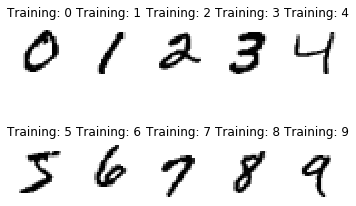

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.axis('off')
  index = np.where(y_train == i)[0][0]
  plt.imshow(x_train[index,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('Training: %i' % y_train[index])
plt.show()

Each image is 28 pixels by 28 pixels. In this lab session, we flatten this array into a vector of 28x28 = 784 numbers.

### Write the code to flatten the data:

In [3]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

### Write the code to normalize pixel intensity between 0 and 1 of images:

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.

In this lab session, we're going to code our labels as "one-hot vectors".

**What is  one-hot encoding?**

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the $n^{th}$ digit will be represented as a vector which is 1 in the $n^{th}$ dimension. For example, label for digit '3' would be $[0,0,0,1,0,0,0,0,0,0]$. 
One advantage of "one-hot encoding" is that it corresponds to the true probabality distribution of a sample (the probability is one for true true class, zero otherwise). This makes it easier to compare with the predicted probality distribution.


### 3) Convert the labels to one-hot vectors (using the function "to_categorical" available in Keras):

In [5]:
num_classes = 10
z_train = tf.keras.utils.to_categorical(y_train, num_classes)
z_test = tf.keras.utils.to_categorical(y_test, num_classes)

## II. Multinomial Logistic Regression

Every image in MNIST is of a handwritten digit between zero and nine. So there are only ten possible things that a given image can be. For a given image, we want to compute the probabilities for it being each digit. In this part, we will use a softmax regression model:

$$y = \mathrm{softmax}(Wx+b)$$

where $\mathrm{softmax}(\cdot)$ is the [normalized exponential function](https://en.wikipedia.org/wiki/Softmax_function) which is used for multinomial logistic regression.

### Define a Keras network architecture for Multinomial Logistic Regression
Based on the [Sequential API](https://keras.io/models/sequential/) to stack the layers in the tf.keras model, 
we use a [Dense layer](https://keras.io/api/layers/core_layers/dense/) to define the softmax regression.
The sequential Keras model is a linear stack of layers. You can create a sequential model by passing a list of layer instances to the constructor. Among the layer instances, you can use:
  - regular densely-connected layer using [Dense](https://keras.io/api/layers/core_layers/dense/) 
  - Regularization layer such that [L1/L2 penalty for input activities](https://keras.io/api/layers/regularization_layers/activity_regularization/) or [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

**Why Dropout regularization?**:
Here we are going to use a
[Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) as regularization one. Unlike L1 and L2 regularization, dropout doesn't rely on penalizing the cost function. Instead, in dropout we modify the network itself by randomly setting some input units to 0 with at each step during training time. The rationale behind dropout is that only the weights of the most useful units will be significantly updated during the training (while the less significant will stay close to zero). This forces the  network to learn more robust features that are useful in conjunction with many different random subsets of the other units, which helps to prevent overfitting.

One advantage of dropout is that it is very computationally cheap, and quite versatile for neural nets (it can be directly applied to different networks architecture, distributed or not), while it can be a very effective regularizer.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# remove deprecated warning for tensorflow 2.0
import logging
logging.getLogger('tensorflow').disabled = True


# y = softmax (Wx+b)
model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=(784,)))

### How many trainable parameters are there?

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Specify the loss function and the optimization algorithm (+ the metrics)

We now have to define the loss function. We try to minimize that error, and the smaller the error margin, the better our model is. Here the categorical "cross-entropy" is used as the loss of the model. It's defined as:

$$H_{y}(z) = -\sum_{i=1}^K  y_i \log(z_i)$$

where $z$ is our predicted probability distribution (thus $z_i$ is the  predicted probability for the $i$th class), and $y$ is the true distribution (the one-hot vector with the digit labels, thus $y_i=1$ if the sample belongs to the $i$th class, $0$ otherwise). This loss is averaged over all samples in the training set.



**Why using cross-entropy?** 

This loss function is commonly used to train neural networks:
- other usual loss derived from the global accuracy like the miss-classification rate are stepwise (non-smooth) functions harder to optimize than cross-entropy,
- cross-entropy is based on the predicted class probabilities, which is more informative than the only predicted labels
- compared to the quadratic loss, where we square the difference between the true probabily (the one-hot-vector) and the predicted one, cross-entropy loss function for a classification problem often leads to faster training as well as improved generalization.

Note also than the cross-entropy function leads to the same loss function than the logistic regression one (derived from the likelihood of the logistic model), called the "_log-loss_".


**Which optimization algorithm:** now we need to specify the optimization algorithm that will be used to minimized the loss function. There exists many variants of stochastic gradient descent especially to select and adapt the learning rate (the list of the optimizers available in keras is [here](https://keras.io/api/optimizers/)).
Here, we will use [RMSprop](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp).

**Which metric:** 
We will also specify a metric to follow the convergence of the training step. Here  `accuracy`, which is the rate of correct classification (one minus the miss-classification rate)

We can now config the Keras model with the loss function, the optimization algorithm and the metric with the `compile()`method on the model (see https://keras.io/api/models/model_training_apis/#compile-method):  

In [8]:
optimizer= tf.keras.optimizers.RMSprop()
# config the model with losses, optimize and metrics 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


### Write the code to train the model:
This is simply done with the `fit()` method (see 
https://keras.io/api/models/model_training_apis/#fit-method)

In [9]:
# Stochastic gradient descent parameters
batch_size = 128 # number of samples to average to compute the gradient
epochs = 20 # number of sweep over the whole training set

history = model.fit(x_train, z_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, z_test))

Epoch 1/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5968 - accuracy: 0.8496 - val_loss: 0.3414 - val_accuracy: 0.9081
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3306 - accuracy: 0.9082 - val_loss: 0.3007 - val_accuracy: 0.9156
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3017 - accuracy: 0.9163 - val_loss: 0.2875 - val_accuracy: 0.9178
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2885 - accuracy: 0.9191 - val_loss: 0.2780 - val_accuracy: 0.9226
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2804 - accuracy: 0.9216 - val_loss: 0.2752 - val_accuracy: 0.9244
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.2748 - accuracy: 0.9230 - val_loss: 0.2726 - val_accuracy: 0.9241
Epoch 7/20
469/469 [==============================] - 7s 15ms/step - loss: 0.2707 - accuracy: 0.9251 - val_loss: 0.2709 - val_accuracy: 0.9247
Epo

To study the convergence of the training step, we will plot the evolution of the accuracy for both training and testing data with respect to the epochs. The code to do this is provided below.

### Study the convergence figure and the evaluation score.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


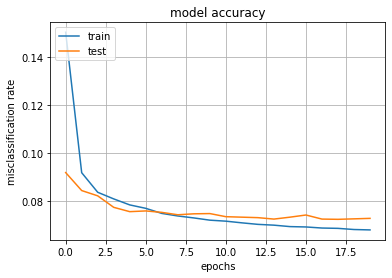

Test cross-entropy loss: 0.2700946033000946
Test misclassification rate: 0.07279998064041138
Test accuracy: 0.9272000193595886


In [10]:
# list all data in history
print(history.history.keys())

#Visualize history (loss vs epochs)
plt.figure()
plt.plot(1-np.asarray(history.history['accuracy']))
plt.plot(1-np.asarray(history.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('misclassification rate')  
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.grid('on')
plt.show()

score = model.evaluate(x_test, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])


Is that good? Compare your results with the score of the current best models: https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results

### Visualize the incorrect predictions:

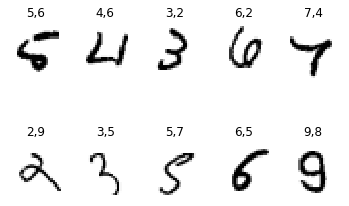

In [11]:
z_pred = model.predict(x_test)


y_pred = np.argmax(z_pred,axis=1)
index = np.where(y_pred - y_test != 0)
im_test = x_test.reshape(10000, 28, 28)

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.axis('off')
  plt.imshow(im_test[index[0][i],:,:], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title(str(y_test[index[0][i]])+','+str(y_pred[index[0][i]]) )
plt.show()

### Study the confusion matrix:

Normalized confusion matrix


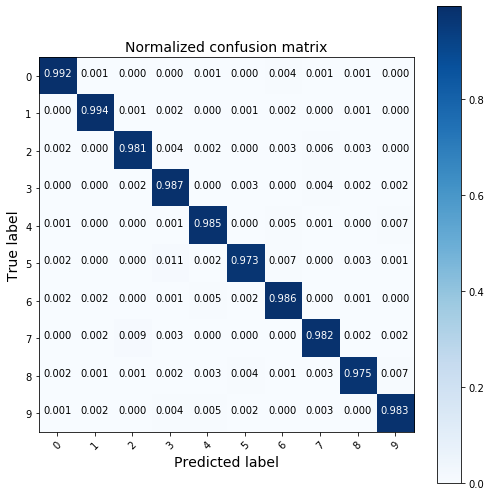

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## III. Multiple layer network

You have tested above a linear classification rule with the logistic regression model. To see if you can improve the results, we are going to consider a nonlinear classification algorithm by adding some hidden layers. 

Neural nets use nonlinear activation functions for the units, i.e. the neurons, of the hidden layers to define the output of these units given the input. Logistic function (sometimes called *sigmoid*) or other sigmoïdal functions as the hyperbolic tangent 'tanh' are typically used since the 90's and 2000's. However these functions appear to be badly adapted to some deep neural net architectures like convolutional networks.
Adoption of the  rectified linear unit (ReLU) activation function in the 2010's may be considered one of the few milestones that now permit the routine development of very deep neural networks, for several reasons:

1. **Counter the _vanishing gradient problem_**

   A general problem with the logistic or hyperbolic tangent 'tanh' functions is that they saturate. For instance the logistic snap to 1.0 for large positive input and  snap to -1 for large negative input, and is only really sensitive to changes when the input is near 0. 

   Layers deep in large networks using these nonlinear activation functions fail to receive useful gradient information. Error is back propagated through the network from the outputs and used to update the weights. The amount of error decreases dramatically with each additional layer through which it is propagated, given the derivative of the chosen activation function. This is called the *vanishing gradient problem* and prevents deep networks from learning effectively. 
  
   Because ReLU is piecewise linear, it preserves many of the properties that make linear models easy to optimize with gradient-based methods. In particular, it is linear for large positive values which prevent from the *vanishing gradient problem*. It also preserves many of the properties that make linear models generalize well. Yet, it is a nonlinear function as negative values are always output as zero: this allows one to obtain more flexible prediction rules than just linear ones. This yields universal function approximators.

2. **Make computation cheaper!**

    ReLU is very cheap to compute: no need for any multiplication or call of complex function (and the gradient is super simple: 1 for positive value and 0 for negative value). This is useful when the number of units is tens of millions or more in deep architectures!


### Build a multiple layer dense network with ReLU activation for the hidden layer

(10000, 784)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
469/469 [==============================] - 9s 18ms/step - loss: 0.2444 - accuracy: 0.9246 

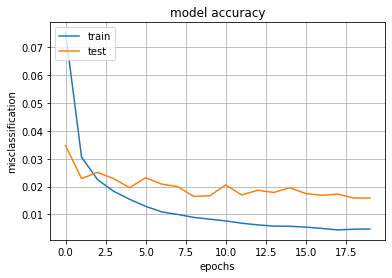

Test cross-entropy loss: 0.12300080806016922
Test misclassification rate: 0.015900015830993652
Test accuracy: 0.9840999841690063


In [13]:
from tensorflow.keras.layers import Dropout

print(x_test.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, z_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, z_test))
score = model.evaluate(x_test, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Visualize history (loss vs epochs)
plt.figure()
plt.plot(1-np.asarray(history.history['accuracy']))
plt.plot(1-np.asarray(history.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('misclassification')  
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.grid('on')
plt.show()

score = model.evaluate(x_test, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])

We reach now 98.4% of correct classification!

### Visualize the incorrect predictions:

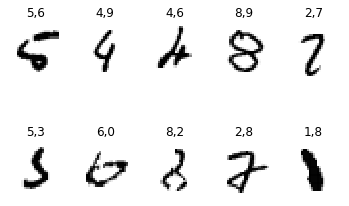

In [14]:
z_pred = model.predict(x_test)


y_pred = np.argmax(z_pred,axis=1)
index = np.where(y_pred - y_test != 0)
im_test = x_test.reshape(10000, 28, 28)

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.axis('off')
  plt.imshow(im_test[index[0][i],:,:], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title(str(y_test[index[0][i]])+','+str(y_pred[index[0][i]]) )
plt.show()